# Developing an AI application

Going forward, AI algorithms will be incorporated into more and more everyday applications. For example, you might want to include an image classifier in a smart phone app. To do this, you'd use a deep learning model trained on hundreds of thousands of images as part of the overall application architecture. A large part of software development in the future will be using these types of models as common parts of applications. 

In this project, you'll train an image classifier to recognize different species of flowers. You can imagine using something like this in a phone app that tells you the name of the flower your camera is looking at. In practice you'd train this classifier, then export it for use in your application. We'll be using [this dataset](http://www.robots.ox.ac.uk/~vgg/data/flowers/102/index.html) of 102 flower categories, you can see a few examples below. 

<img src='assets/Flowers.png' width=500px>

The project is broken down into multiple steps:

* Load and preprocess the image dataset
* Train the image classifier on your dataset
* Use the trained classifier to predict image content

We'll lead you through each part which you'll implement in Python.

When you've completed this project, you'll have an application that can be trained on any set of labeled images. Here your network will be learning about flowers and end up as a command line application. But, what you do with your new skills depends on your imagination and effort in building a dataset. For example, imagine an app where you take a picture of a car, it tells you what the make and model is, then looks up information about it. Go build your own dataset and make something new.

First up is importing the packages you'll need. It's good practice to keep all the imports at the beginning of your code. As you work through this notebook and find you need to import a package, make sure to add the import up here.

In [1]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
from torchvision import datasets, transforms,models
import json
import PIL
from PIL import Image



## Load the data

Here you'll use `torchvision` to load the data ([documentation](http://pytorch.org/docs/0.3.0/torchvision/index.html)). The data should be included alongside this notebook, otherwise you can [download it here](https://s3.amazonaws.com/content.udacity-data.com/nd089/flower_data.tar.gz). The dataset is split into three parts, training, validation, and testing. For the training, you'll want to apply transformations such as random scaling, cropping, and flipping. This will help the network generalize leading to better performance. You'll also need to make sure the input data is resized to 224x224 pixels as required by the pre-trained networks.

The validation and testing sets are used to measure the model's performance on data it hasn't seen yet. For this you don't want any scaling or rotation transformations, but you'll need to resize then crop the images to the appropriate size.

The pre-trained networks you'll use were trained on the ImageNet dataset where each color channel was normalized separately. For all three sets you'll need to normalize the means and standard deviations of the images to what the network expects. For the means, it's `[0.485, 0.456, 0.406]` and for the standard deviations `[0.229, 0.224, 0.225]`, calculated from the ImageNet images.  These values will shift each color channel to be centered at 0 and range from -1 to 1.
 

In [2]:
data_dir = 'flowers'
train_dir = data_dir + '/train'
valid_dir = data_dir + '/valid'
test_dir = data_dir + '/test'

In [3]:

train_transform = transforms.Compose([transforms.RandomRotation(30),
                                      transforms.RandomResizedCrop(224),
                                      transforms.RandomHorizontalFlip(),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.485, 0.456, 0.406], 
                                                            [0.229, 0.224, 0.225])
                                     ]) 

valid_transform = transforms.Compose([transforms.Resize(224),
                                      transforms.CenterCrop(224),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.485, 0.456, 0.406], 
                                                            [0.229, 0.224, 0.225])
                                     ])

test_transform = transforms.Compose([transforms.Resize(224),
                                     transforms.CenterCrop(224),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.485, 0.456, 0.406], 
                                                            [0.229, 0.224, 0.225])
                                     ])

train_data = datasets.ImageFolder(train_dir, transform=train_transform)
valid_data = datasets.ImageFolder(valid_dir, transform=valid_transform)
test_data = datasets.ImageFolder(test_dir, transform=test_transform)


trainloader = torch.utils.data.DataLoader(train_data, batch_size=64, shuffle=True)
validloader = torch.utils.data.DataLoader(valid_data, batch_size=32)
testloader = torch.utils.data.DataLoader(test_data, batch_size=32)


### Label mapping

You'll also need to load in a mapping from category label to category name. You can find this in the file `cat_to_name.json`. It's a JSON object which you can read in with the [`json` module](https://docs.python.org/2/library/json.html). This will give you a dictionary mapping the integer encoded categories to the actual names of the flowers.

In [4]:
with open('cat_to_name.json', 'r') as f:
    cat_to_name = json.load(f)
    
print(cat_to_name)

{'21': 'fire lily', '3': 'canterbury bells', '45': 'bolero deep blue', '1': 'pink primrose', '34': 'mexican aster', '27': 'prince of wales feathers', '7': 'moon orchid', '16': 'globe-flower', '25': 'grape hyacinth', '26': 'corn poppy', '79': 'toad lily', '39': 'siam tulip', '24': 'red ginger', '67': 'spring crocus', '35': 'alpine sea holly', '32': 'garden phlox', '10': 'globe thistle', '6': 'tiger lily', '93': 'ball moss', '33': 'love in the mist', '9': 'monkshood', '102': 'blackberry lily', '14': 'spear thistle', '19': 'balloon flower', '100': 'blanket flower', '13': 'king protea', '49': 'oxeye daisy', '15': 'yellow iris', '61': 'cautleya spicata', '31': 'carnation', '64': 'silverbush', '68': 'bearded iris', '63': 'black-eyed susan', '69': 'windflower', '62': 'japanese anemone', '20': 'giant white arum lily', '38': 'great masterwort', '4': 'sweet pea', '86': 'tree mallow', '101': 'trumpet creeper', '42': 'daffodil', '22': 'pincushion flower', '2': 'hard-leaved pocket orchid', '54': 's

# Building and training the classifier

Now that the data is ready, it's time to build and train the classifier. As usual, you should use one of the pretrained models from `torchvision.models` to get the image features. Build and train a new feed-forward classifier using those features.

We're going to leave this part up to you. If you want to talk through it with someone, chat with your fellow students! You can also ask questions on the forums or join the instructors in office hours.

Refer to [the rubric](https://review.udacity.com/#!/rubrics/1663/view) for guidance on successfully completing this section. Things you'll need to do:

* Load a [pre-trained network](http://pytorch.org/docs/master/torchvision/models.html) (If you need a starting point, the VGG networks work great and are straightforward to use)
* Define a new, untrained feed-forward network as a classifier, using ReLU activations and dropout
* Train the classifier layers using backpropagation using the pre-trained network to get the features
* Track the loss and accuracy on the validation set to determine the best hyperparameters

We've left a cell open for you below, but use as many as you need. Our advice is to break the problem up into smaller parts you can run separately. Check that each part is doing what you expect, then move on to the next. You'll likely find that as you work through each part, you'll need to go back and modify your previous code. This is totally normal!

When training make sure you're updating only the weights of the feed-forward network. You should be able to get the validation accuracy above 70% if you build everything right. Make sure to try different hyperparameters (learning rate, units in the classifier, epochs, etc) to find the best model. Save those hyperparameters to use as default values in the next part of the project.

In [5]:

model = models.vgg16(pretrained=True)
model

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.torch/models/vgg16-397923af.pth
100%|██████████| 553433881/553433881 [00:21<00:00, 25391099.32it/s]


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (17): Conv2d

In [6]:
for param in model.parameters():
    param.requires_grad = False

from collections import OrderedDict
NewClassifier = nn.Sequential(OrderedDict([
                          ('fc1', nn.Linear(25088, 1000)),
                          ('relu', nn.ReLU()),
                          ('dropout', nn.Dropout(p=0.5)),
                          ('fc2', nn.Linear(1000, 102)),
                          ('output', nn.LogSoftmax(dim=1))
                          ]))

model.classifier = NewClassifier

model.classifier

Sequential(
  (fc1): Linear(in_features=25088, out_features=1000, bias=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.5)
  (fc2): Linear(in_features=1000, out_features=102, bias=True)
  (output): LogSoftmax()
)

In [7]:
criterion = nn.NLLLoss()
optimizer = optim.Adam(model.classifier.parameters(), lr=0.001)

In [8]:
device=['cuda','cpu']

epochs = 8
print_every = 40
steps = 0


print('Training Start!')

model.to(device[0])

for e in range(epochs):
    running_loss = 0
    model.train()
    for i, (inputs, labels) in enumerate(trainloader):
        steps += 1
        
        inputs, labels = inputs.to(device[0]), labels.to(device[0])
        
        optimizer.zero_grad()

        outputs = model.forward(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        
        if steps % print_every == 0:
            model.eval()
            
            with torch.no_grad():
                
                valid_loss = 0
                valid_accuracy = 0

                for valid_inputs, valid_labels in validloader:
                    valid_inputs, valid_labels = valid_inputs.to(device[0]), valid_labels.to(device[0])
                    
                    valid_output = model.forward(valid_inputs)
                    valid_loss += criterion(valid_output, valid_labels).item()

                    ps = torch.exp(valid_output)
                    equality = (valid_labels.data == ps.max(dim=1)[1])
                    valid_accuracy += equality.type(torch.FloatTensor).mean()


                print("Epoch: {}/{}... ".format(e+1, epochs),
                      "Train Loss: {:.4f}...".format(running_loss),
                      "Validation Loss: {:.4f}...".format(valid_loss),
                      "Validation Accuracy: {:.4f}...".format(valid_accuracy/len(validloader)))

                running_loss = 0

                model.train()

print('Finish Training!')

Training Start!
Epoch: 1/8...  Train Loss: 151.6387... Validation Loss: 51.3935... Validation Accuracy: 0.5521...
Epoch: 1/8...  Train Loss: 91.8486... Validation Loss: 27.9404... Validation Accuracy: 0.7366...
Epoch: 2/8...  Train Loss: 27.7273... Validation Loss: 22.6133... Validation Accuracy: 0.7726...
Epoch: 2/8...  Train Loss: 64.8940... Validation Loss: 19.5207... Validation Accuracy: 0.7931...
Epoch: 2/8...  Train Loss: 62.3165... Validation Loss: 16.7882... Validation Accuracy: 0.8229...
Epoch: 3/8...  Train Loss: 48.2320... Validation Loss: 15.5370... Validation Accuracy: 0.8419...
Epoch: 3/8...  Train Loss: 55.7558... Validation Loss: 14.6435... Validation Accuracy: 0.8491...
Epoch: 4/8...  Train Loss: 13.9635... Validation Loss: 13.6873... Validation Accuracy: 0.8599...
Epoch: 4/8...  Train Loss: 49.7287... Validation Loss: 13.4372... Validation Accuracy: 0.8560...
Epoch: 4/8...  Train Loss: 50.1148... Validation Loss: 12.7654... Validation Accuracy: 0.8710...
Epoch: 5/8...

## Testing your network

It's good practice to test your trained network on test data, images the network has never seen either in training or validation. This will give you a good estimate for the model's performance on completely new images. Run the test images through the network and measure the accuracy, the same way you did validation. You should be able to reach around 70% accuracy on the test set if the model has been trained well.

In [9]:

test_loss = 0
test_accuracy = 0

model.eval()

for test_inputs, test_labels in testloader:
    
    with torch.no_grad():
        test_inputs, test_labels = test_inputs.to(device[0]), test_labels.to(device[0])
            
        test_output = model.forward(test_inputs)
        loss = criterion(test_output, test_labels)
        test_loss += loss.item()

        ps = torch.exp(test_output)
        equality = (test_labels.data == ps.max(dim=1)[1])

        test_accuracy += equality.type(torch.FloatTensor).mean()

print("Test Loss: {:.3f}...".format(test_loss),
      "Test Accuracy : {:.3f}".format(test_accuracy/len(testloader)))


Test Loss: 13.562... Test Accuracy : 0.873


## Save the checkpoint

Now that your network is trained, save the model so you can load it later for making predictions. You probably want to save other things such as the mapping of classes to indices which you get from one of the image datasets: `image_datasets['train'].class_to_idx`. You can attach this to the model as an attribute which makes inference easier later on.

```model.class_to_idx = image_datasets['train'].class_to_idx```

Remember that you'll want to completely rebuild the model later so you can use it for inference. Make sure to include any information you need in the checkpoint. If you want to load the model and keep training, you'll want to save the number of epochs as well as the optimizer state, `optimizer.state_dict`. You'll likely want to use this trained model in the next part of the project, so best to save it now.

In [10]:
 
checkpoint = {'model': model,
              'classifier':NewClassifier,
              'class_to_idx': train_data.class_to_idx,
              'state_dict': model.state_dict()}

torch.save(checkpoint, 'checkpoint.pth')


## Loading the checkpoint

At this point it's good to write a function that can load a checkpoint and rebuild the model. That way you can come back to this project and keep working on it without having to retrain the network.

In [11]:

def loadmodel(filepath):
    
    checkpoint = torch.load(filepath)
    model=checkpoint['model']
    model.state_dict=checkpoint['state_dict']
    model.classifier=checkpoint['classifier']
    model.class_to_idx = checkpoint['class_to_idx']
    return model

Newmodel = loadmodel('checkpoint.pth')
Newmodel

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (17): Conv2d

# Inference for classification

Now you'll write a function to use a trained network for inference. That is, you'll pass an image into the network and predict the class of the flower in the image. Write a function called `predict` that takes an image and a model, then returns the top $K$ most likely classes along with the probabilities. It should look like 

```python
probs, classes = predict(image_path, model)
print(probs)
print(classes)
> [ 0.01558163  0.01541934  0.01452626  0.01443549  0.01407339]
> ['70', '3', '45', '62', '55']
```

First you'll need to handle processing the input image such that it can be used in your network. 

## Image Preprocessing

You'll want to use `PIL` to load the image ([documentation](https://pillow.readthedocs.io/en/latest/reference/Image.html)). It's best to write a function that preprocesses the image so it can be used as input for the model. This function should process the images in the same manner used for training. 

First, resize the images where the shortest side is 256 pixels, keeping the aspect ratio. This can be done with the [`thumbnail`](http://pillow.readthedocs.io/en/3.1.x/reference/Image.html#PIL.Image.Image.thumbnail) or [`resize`](http://pillow.readthedocs.io/en/3.1.x/reference/Image.html#PIL.Image.Image.thumbnail) methods. Then you'll need to crop out the center 224x224 portion of the image.

Color channels of images are typically encoded as integers 0-255, but the model expected floats 0-1. You'll need to convert the values. It's easiest with a Numpy array, which you can get from a PIL image like so `np_image = np.array(pil_image)`.

As before, the network expects the images to be normalized in a specific way. For the means, it's `[0.485, 0.456, 0.406]` and for the standard deviations `[0.229, 0.224, 0.225]`. You'll want to subtract the means from each color channel, then divide by the standard deviation. 

And finally, PyTorch expects the color channel to be the first dimension but it's the third dimension in the PIL image and Numpy array. You can reorder dimensions using [`ndarray.transpose`](https://docs.scipy.org/doc/numpy-1.13.0/reference/generated/numpy.ndarray.transpose.html). The color channel needs to be first and retain the order of the other two dimensions.

In [12]:
def process_image(image_path):
    ''' Scales, crops, and normalizes a PIL image for a PyTorch model,
        returns an Numpy array
    '''
    ig = Image.open(image_path)
    
    ig = ig.resize((256,256))
    ig = ig.crop((16,16,240,240))
    
    ig = np.array(ig)/255
    
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    ig = (ig - mean) / std
    ig = ig.transpose(2,0,1)
    
    return ig
    
    

To check your work, the function below converts a PyTorch tensor and displays it in the notebook. If your `process_image` function works, running the output through this function should return the original image (except for the cropped out portions).

giant white arum lily


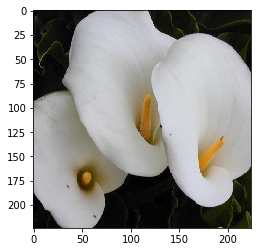

In [13]:
def imshow(image, ax=None, title=None):
    """Imshow for Tensor."""
    if ax is None:
        fig, ax = plt.subplots()
    
    image = image.transpose((1, 2, 0))
    
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    image = std * image + mean
    
    image = np.clip(image, 0, 1)
    
    ax.imshow(image)
    
    return ax

imshow(process_image(train_dir+'/20/image_04901.jpg'))
flower_name = cat_to_name['20']
print(flower_name)

## Class Prediction

Once you can get images in the correct format, it's time to write a function for making predictions with your model. A common practice is to predict the top 5 or so (usually called top-$K$) most probable classes. You'll want to calculate the class probabilities then find the $K$ largest values.

To get the top $K$ largest values in a tensor use [`x.topk(k)`](http://pytorch.org/docs/master/torch.html#torch.topk). This method returns both the highest `k` probabilities and the indices of those probabilities corresponding to the classes. You need to convert from these indices to the actual class labels using `class_to_idx` which hopefully you added to the model or from an `ImageFolder` you used to load the data ([see here](#Save-the-checkpoint)). Make sure to invert the dictionary so you get a mapping from index to class as well.

Again, this method should take a path to an image and a model checkpoint, then return the probabilities and classes.

```python
probs, classes = predict(image_path, model)
print(probs)
print(classes)
> [ 0.01558163  0.01541934  0.01452626  0.01443549  0.01407339]
> ['70', '3', '45', '62', '55']
```

In [14]:
def predict(image_path, model, topk=5):
    ''' Predict the class (or classes) of an image using a trained deep learning model.
    '''
    
    image = process_image(image_path)
    image = torch.from_numpy(np.array([image])).float()
    model.eval()

    image = image.cuda()
    output = model.forward(image)
    ps = torch.exp(output).topk(topk)
    
    prob = ps[0][0]
    index = ps[1][0]
    
    convert = []
    for i in range(len(model.class_to_idx.items())):
        convert.append(list(model.class_to_idx.items())[i][0])

    label = []
    for i in range(topk):
        label.append(convert[index[i]])
    prob = prob.cpu()
    prob = prob.detach().numpy()
    
    
    return prob,label
    

In [15]:
proba,classess = predict('flowers/valid/102/image_08040.jpg',Newmodel)

print(proba)
print(classess)

[  1.00000000e+00   5.32779550e-11   2.81827968e-12   1.49177437e-13
   4.09630046e-14]
['102', '79', '18', '23', '6']


## Sanity Checking

Now that you can use a trained model for predictions, check to make sure it makes sense. Even if the testing accuracy is high, it's always good to check that there aren't obvious bugs. Use `matplotlib` to plot the probabilities for the top 5 classes as a bar graph, along with the input image. It should look like this:

<img src='assets/inference_example.png' width=300px>

You can convert from the class integer encoding to actual flower names with the `cat_to_name.json` file (should have been loaded earlier in the notebook). To show a PyTorch tensor as an image, use the `imshow` function defined above.

cape flower
[  9.99187768e-01   2.08861180e-04   1.53377550e-04   1.05643398e-04
   9.01049789e-05]
['37', '88', '84', '94', '32']
['cape flower', 'cyclamen', 'columbine', 'foxglove', 'garden phlox']
[1.0, 5.3277955e-11, 2.8182797e-12, 1.4917744e-13, 4.0963005e-14]


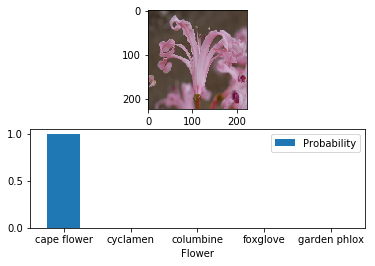

In [16]:

image_path = 'flowers/valid/37/image_03822.jpg'
flowername = cat_to_name['37']
print(flowername)

prob,classes = predict(image_path,Newmodel)

print(prob)
print(classes)


labels = []
for i in classes:
    labels.append(cat_to_name[i])

probability = []
for i in proba:
    probability.append(i)

print(labels)
print(probability)

flower = pd.DataFrame({ 'Flower': labels, 'Probability': probability })

f, (ax1, ax2) = plt.subplots(2,1)


imshow(process_image(image_path),ax = ax1)
flower.plot('Flower','Probability',kind = 'bar',rot = 0,ax = ax2)